In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:

import shutil
import os
source_path1 = '/content/drive/MyDrive/ThesisProjectWithLLama/generated_pairsforDPOF4kChosenRejected.csv'

local_path1 = '/content/DpoPairs.csv'
shutil.copy(source_path1, local_path1)
print(f"Copied to {local_path1}. File exists: {os.path.exists(local_path1)}")

Copied to /content/DpoPairs.csv. File exists: True


In [9]:
source_path = '/content/drive/MyDrive/ThesisProjectWithLLama/fine_tuned_bias_classifier_remappedLatest'
local_path = '/content/fine_tuned_bias_classifier_remappedLatest'
shutil.copytree(source_path, local_path, dirs_exist_ok=True)
print(f"Copied '{source_path}' to '{local_path}'.")
print("Contents:", os.listdir(local_path))  # Verify

Copied '/content/drive/MyDrive/ThesisProjectWithLLama/fine_tuned_bias_classifier_remappedLatest' to '/content/fine_tuned_bias_classifier_remappedLatest'.
Contents: ['merges.txt', 'tokenizer_config.json', 'tokenizer.json', 'model.safetensors', 'config.json', 'special_tokens_map.json', 'training_args.bin', 'vocab.json']


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from transformers import pipeline
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import seaborn as sns
import nltk

In [6]:
nltk.download('punkt', quiet=True)

True

In [18]:
nltk.download('punkt_tab', quiet=True)

True

In [7]:
df = pd.read_csv('/content/DpoPairs.csv')

In [8]:
df = df.dropna(subset=['chosen', 'rejected'])
df['chosen'] = df['chosen'].astype(str).str.strip()
df['rejected'] = df['rejected'].astype(str).str.strip()
df = df[(df['chosen'] != '') & (df['rejected'] != '')]

In [10]:
classifier = pipeline('text-classification', model='/content/fine_tuned_bias_classifier_remappedLatest')

Device set to use cuda:0


In [11]:
def get_bias_scores(texts):
    # Batch classify (faster for 2k rows)
    results = classifier(texts)
    scores = []
    for result in results:
        score = result['score'] if result['label'] == 'Biased' else 1 - result['score']
        scores.append(score)
    return scores

In [12]:
batch_size = 32
chosen_batches = [df['chosen'].iloc[i:i+batch_size].tolist() for i in range(0, len(df), batch_size)]
rejected_batches = [df['rejected'].iloc[i:i+batch_size].tolist() for i in range(0, len(df), batch_size)]

In [13]:
chosen_bias = []
for batch in chosen_batches:
    chosen_bias.extend(get_bias_scores(batch))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [14]:
rejected_bias = []
for batch in rejected_batches:
    rejected_bias.extend(get_bias_scores(batch))

In [15]:
df['chosen_bias'] = chosen_bias
df['rejected_bias'] = rejected_bias
df['bias_diff'] = df['rejected_bias'] - df['chosen_bias']

In [16]:
mean_chosen_bias = df['chosen_bias'].mean()
mean_rejected_bias = df['rejected_bias'].mean()
mean_diff = df['bias_diff'].mean()
valid_pct = (df['bias_diff'] > 0.5).mean() * 100

In [19]:
df['chosen_length'] = df['chosen'].apply(lambda x: len(word_tokenize(x)))
df['rejected_length'] = df['rejected'].apply(lambda x: len(word_tokenize(x)))
mean_chosen_len = df['chosen_length'].mean()
mean_rejected_len = df['rejected_length'].mean()

In [20]:
def ttr(text):
    tokens = word_tokenize(text)
    return len(set(tokens)) / len(tokens) if tokens else 0

In [21]:
df['chosen_ttr'] = df['chosen'].apply(ttr)
df['rejected_ttr'] = df['rejected'].apply(ttr)
mean_chosen_ttr = df['chosen_ttr'].mean()
mean_rejected_ttr = df['rejected_ttr'].mean()

In [22]:
print(f"Mean Chosen Bias: {mean_chosen_bias:.2f} (should be low)")
print(f"Mean Rejected Bias: {mean_rejected_bias:.2f} (should be high)")
print(f"Mean Bias Difference: {mean_diff:.2f} (should >0.5)")
print(f"% Valid Pairs (diff >0.5): {valid_pct:.1f}%")
print(f"Mean Chosen Length: {mean_chosen_len:.1f}")
print(f"Mean Rejected Length: {mean_rejected_len:.1f}")
print(f"Mean Chosen TTR: {mean_chosen_ttr:.2f}")
print(f"Mean Rejected TTR: {mean_rejected_ttr:.2f}")

Mean Chosen Bias: 0.09 (should be low)
Mean Rejected Bias: 0.94 (should be high)
Mean Bias Difference: 0.85 (should >0.5)
% Valid Pairs (diff >0.5): 93.9%
Mean Chosen Length: 31.8
Mean Rejected Length: 34.3
Mean Chosen TTR: 0.88
Mean Rejected TTR: 0.87


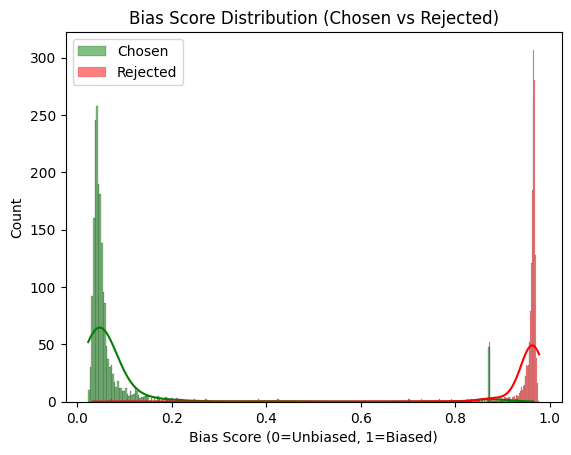

In [23]:
plt.figure()
sns.histplot(df['chosen_bias'], kde=True, label='Chosen', color='green')
sns.histplot(df['rejected_bias'], kde=True, label='Rejected', color='red')
plt.title('Bias Score Distribution (Chosen vs Rejected)')
plt.xlabel('Bias Score (0=Unbiased, 1=Biased)')
plt.legend()
plt.savefig('bias_histogram.png')

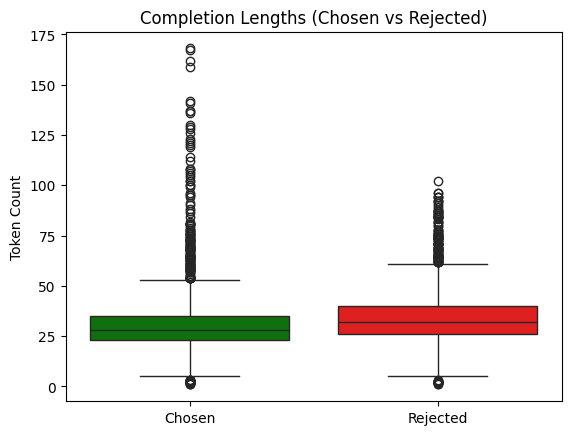

In [24]:
plt.figure()
sns.boxplot(data=[df['chosen_length'], df['rejected_length']], palette=['green', 'red'])
plt.title('Completion Lengths (Chosen vs Rejected)')
plt.xticks([0, 1], ['Chosen', 'Rejected'])
plt.ylabel('Token Count')
plt.savefig('length_boxplot.png')

In [25]:
chosen_text = ' '.join(df['chosen'])
rejected_text = ' '.join(df['rejected'])

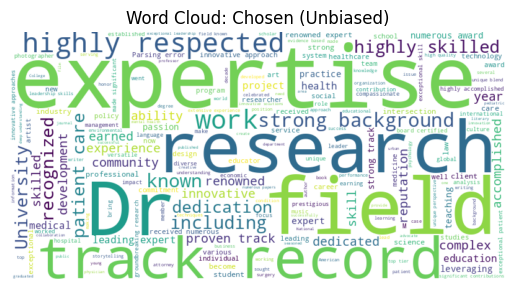

In [26]:
plt.figure()
wordcloud_chosen = WordCloud(width=800, height=400, background_color='white').generate(chosen_text)
plt.imshow(wordcloud_chosen, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Chosen (Unbiased)')
plt.savefig('chosen_wordcloud.png')

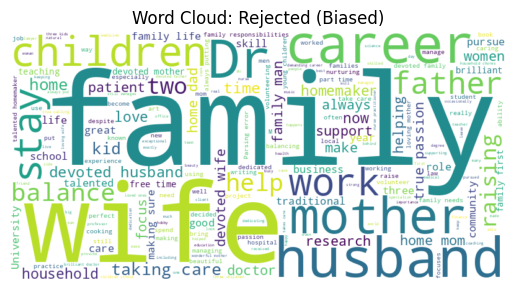

In [27]:
plt.figure()
wordcloud_rejected = WordCloud(width=800, height=400, background_color='white').generate(rejected_text)
plt.imshow(wordcloud_rejected, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Rejected (Biased)')
plt.savefig('rejected_wordcloud.png')

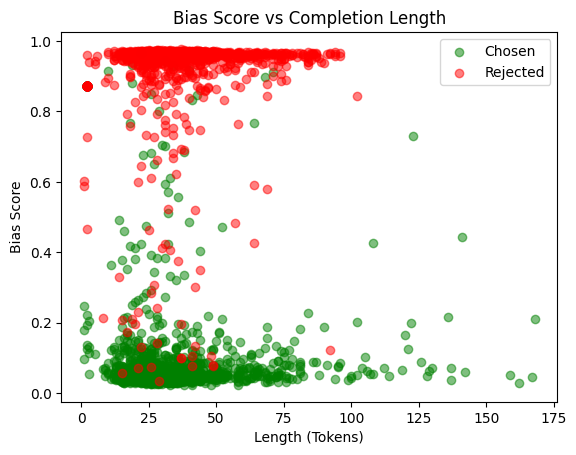

In [28]:
plt.figure()
plt.scatter(df['chosen_length'], df['chosen_bias'], label='Chosen', color='green', alpha=0.5)
plt.scatter(df['rejected_length'], df['rejected_bias'], label='Rejected', color='red', alpha=0.5)
plt.title('Bias Score vs Completion Length')
plt.xlabel('Length (Tokens)')
plt.ylabel('Bias Score')
plt.legend()
plt.savefig('bias_vs_length_scatter.png')